In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from lens import ray
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate

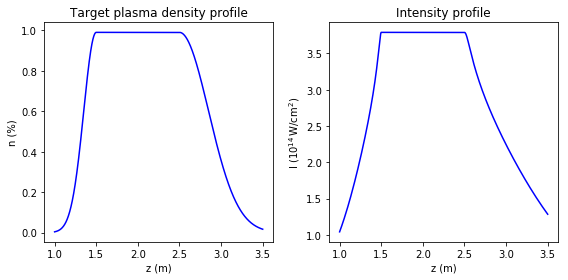

In [2]:
# First test of a tailored plasma profile (ray approximation)
# Temporal pulse shape, assume 50fs duration
def f(I, t):
    return ionization.gaussian_field(I, t, .375, 50).real
I = np.linspace(0, 10, 1000)
t = np.linspace(-100, 100, 1000)
# Diatomic hydrogen - intensity from ionization fraction
g = adk.intensity_func(15.426, I, t, f, 1)

# Create the z grid
NEnt = 1000
NBody = 2000
NExit = 2000
Nz = NEnt + NBody + NExit
d1 = 1e6
d2 = 1.5e6
d3 = 2.5e6
d4 = 3.5e6
zEnt = np.linspace(d1, d2, NEnt, False)
zBody = np.linspace(d2, d3, NBody, False)
zExit = np.linspace(d3, d4, NExit)
z = np.concatenate((zEnt, zBody, zExit))

R=10e3
# Create the params for reference
params = {'Nx' : 2**10,
          'Ny' : 2**10,
          'Nz' : 2**8,
          'X' : R*3,
          'Y' : R*3,
          'Z' : d4-d1,
          'z0' : d1,
          'lam' : 0.8,
          'n' : 1.0,
          # Params for the E-field function
          'R' : R,
          }

# Entrance and exit ramps
sigmaEnt = 150e3
sigmaExit = 350e3
nEnt = 0.99*np.exp(-(zEnt-d2)**2/(2*sigmaEnt**2))
nBody = np.zeros(NBody) + 0.99
nExit = 0.99*np.exp(-(zExit-d3)**2/(2*sigmaExit**2))
n = np.concatenate((nEnt, nBody, nExit))

# Calculate the desired intensity profile
I = g(n)

# Plot initial conditions
plt.figure(figsize=(8,4))
# Ionization fraction
plt.subplot(121)
plt.plot(z/1e6, n, 'b-')
plt.title('Target plasma density profile')
plt.xlabel('z (m)')
plt.ylabel('n (%)')
# Intensity profile
plt.subplot(122)
plt.plot(z/1e6, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')

plt.tight_layout()
plt.show()

0.0229543017451


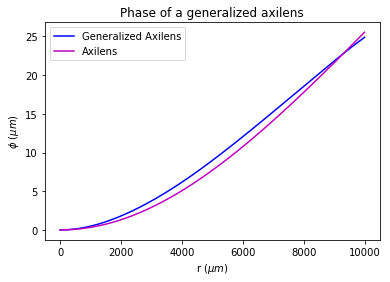

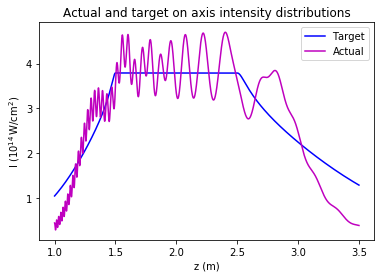

In [3]:
I0, r, phi = ray.uniform_phase(I, z, R)

f0 = d2
dz = d3-d2
phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2

print(I0)
plt.plot(r, abs(phi),'b-',r, abs(phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Generalized Axilens','Axilens'])
plt.show()

params['E0'] = ionization.field_from_intensity(I0)
# Fresnel propagation
k = 2*np.pi/params['lam']
Ediff = laser.fresnel_axis(params['E0']*np.exp(1j*k*phi), r, z, params['lam'])
Idiff = abs(Ediff)**2
# Shift everything by the average
Itot = integrate.simps(I)
Iact = integrate.simps(Idiff)
Idiff = Idiff * (Itot/Iact)


plt.plot(z/1e6, I, 'b', z/1e6, Idiff, 'm-')
plt.title('Actual and target on axis intensity distributions')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

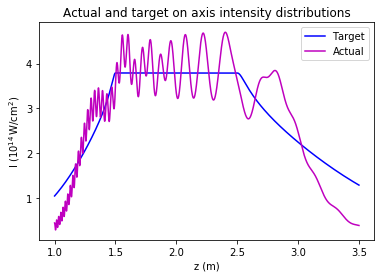

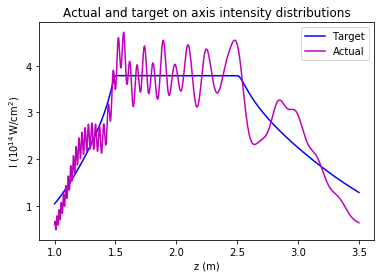

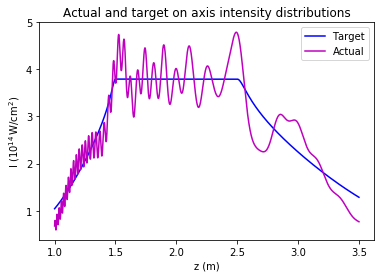

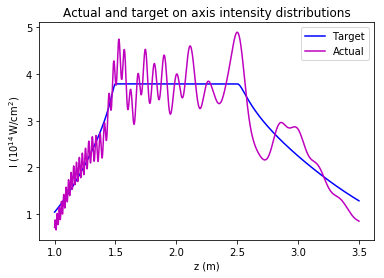

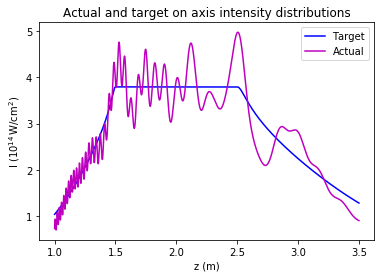

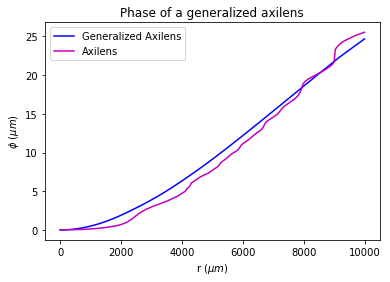

In [4]:
# Attempt to repeatedly correct the target intensity
k = 2*np.pi/params['lam']

Itarget = I
for i in range(0, 5):
    I0, r, phi = ray.uniform_phase(Itarget, z, R)
    Ediff = laser.fresnel_axis(params['E0']*np.exp(1j*k*phi), r, z, params['lam'])
    Idiff = abs(Ediff)**2
    Itot = integrate.simps(I)
    Iact = integrate.simps(Idiff)
    Idiff = Idiff * (Itot/Iact)
    Itarget = Itarget + I - Idiff
    Itarget[Itarget < 0] = 0.01

    plt.plot(z/1e6, I, 'b', z/1e6, Idiff, 'm-')
    plt.title('Actual and target on axis intensity distributions')
    plt.xlabel('z (m)')
    plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
    plt.legend(['Target', 'Actual'])
    plt.show()

plt.plot(r, abs(phi),'b-',r, abs(phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Generalized Axilens','Axilens'])
plt.show()

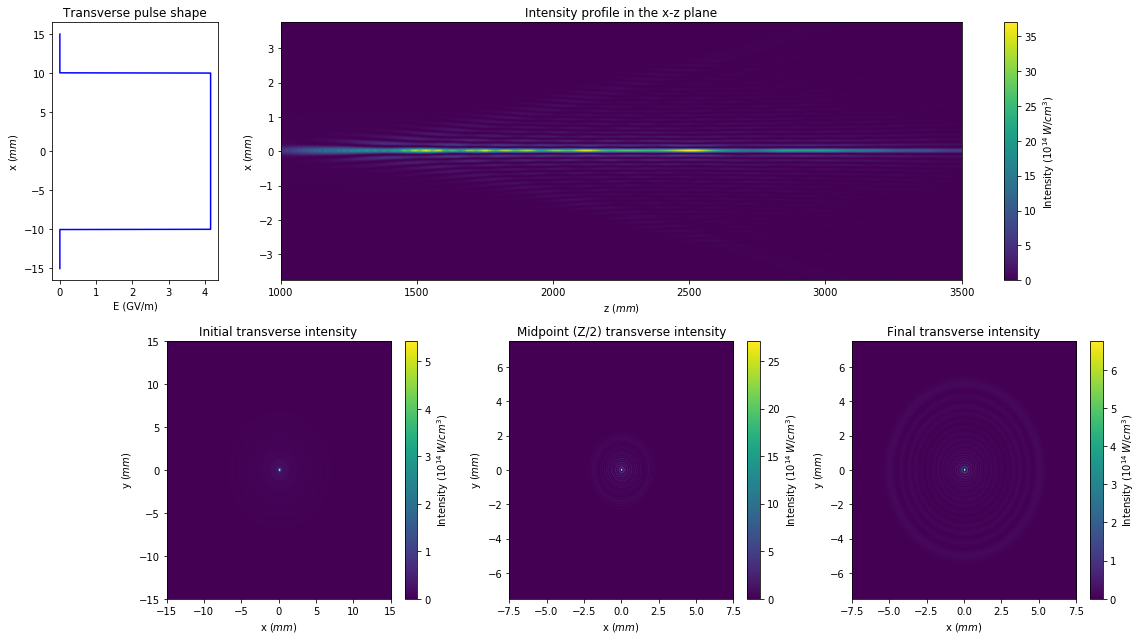

In [5]:
# Create an interpolating function for the phase
phir = interp1d(r, phi)
params['phi'] = phir
# Initial electric field
def Efunc(x, y):
    # Input flatop beam
    R = params['R']
    r = np.sqrt(x**2 + y**2)
    E0 = np.zeros(np.shape(r))
    E0[r < R] = 1.0
    # Generalized Axilens
    k = 2*np.pi / params['lam']
    phi = np.zeros(np.shape(r))
    phi[r < R] = params['phi'](r[r < R])
    T0 = np.exp(1j*k*phi)
    # Initial electric field
    return E0 * T0

path = '/media/robert/Data_Storage/Data/Optics/Axilens/'

directory = 'Generalized_Axilens_Test2'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

0.0229773020475


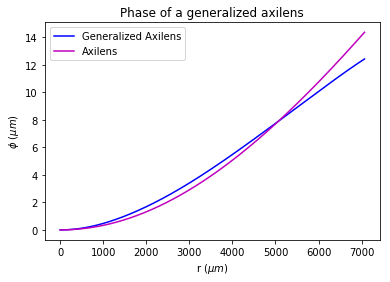

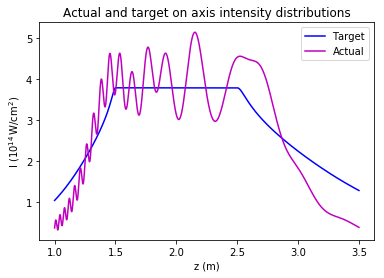

In [6]:
# Similar calculation but with the arbitrary input beam
# Start by recreating the flattop input
N = 1000
R = params['R']
r = np.linspace(0, R, N)
I0 = np.zeros(np.shape(r))
I0[r < R] = 1.0
I0, r, phi = ray.arbitrary_phase(I0, r, I, z)

f0 = d2
dz = d3-d2
phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2

print(I0)
plt.plot(r, abs(phi),'b-',r, abs(phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Generalized Axilens','Axilens'])
plt.show()

params['E0'] = ionization.field_from_intensity(I0)
# Fresnel propagation
k = 2*np.pi/params['lam']
Ediff = laser.fresnel_axis(params['E0']*np.exp(1j*k*phi), r, z, params['lam'])
Idiff = abs(Ediff)**2
# Shift everything by the average
Itot = integrate.simps(I)
Iact = integrate.simps(Idiff)
Idiff = Idiff * (Itot/Iact)


plt.plot(z/1e6, I, 'b', z/1e6, Idiff, 'm-')
plt.title('Actual and target on axis intensity distributions')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

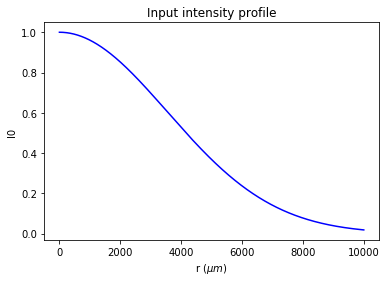

0.0935302744154


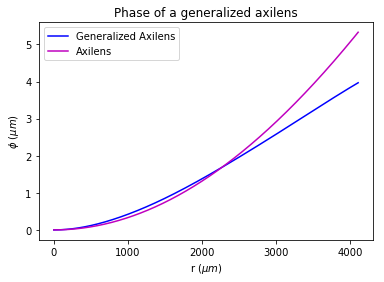

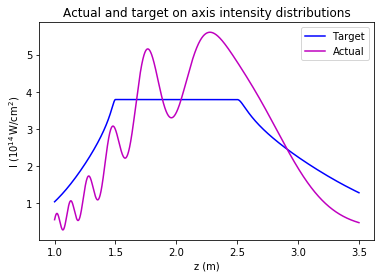

In [7]:
# Now test with a Gaussian input beam

# Similar calculation but with the arbitrary input beam
# Start by recreating the flattop input
N = 10000
R0 = 5e3
R = params['R']
r = np.linspace(0, R, N)
I0 = np.exp(-r**2/R0**2)

plt.plot(r, I0,'b-')
plt.title('Input intensity profile')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'I0')
plt.show()

I0, r, phi = ray.arbitrary_phase(I0, r, I, z)

f0 = d2
dz = d3-d2
phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2

print(I0)
plt.plot(r, abs(phi),'b-',r, abs(phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Generalized Axilens','Axilens'])
plt.show()

params['E0'] = ionization.field_from_intensity(I0)
# Fresnel propagation
k = 2*np.pi/params['lam']
Ediff = laser.fresnel_axis(params['E0']*np.exp(1j*k*phi), r, z, params['lam'])
Idiff = abs(Ediff)**2
# Shift everything by the average
Itot = integrate.simps(I)
Iact = integrate.simps(Idiff)
Idiff = Idiff * (Itot/Iact)


plt.plot(z/1e6, I, 'b', z/1e6, Idiff, 'm-')
plt.title('Actual and target on axis intensity distributions')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

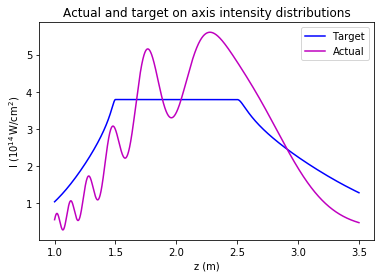

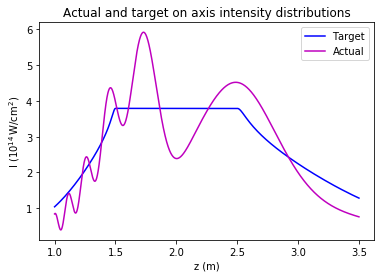

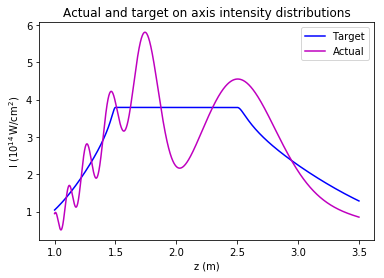

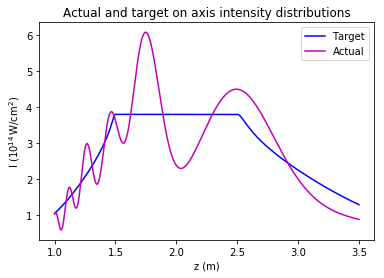

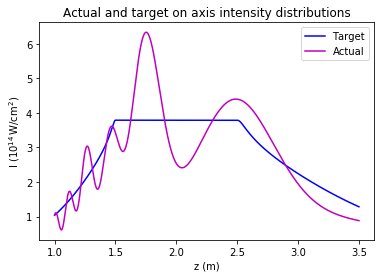

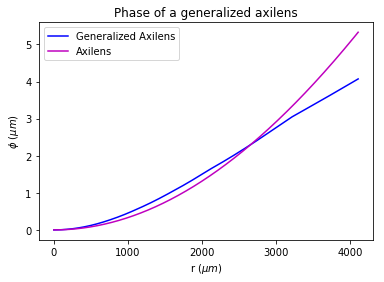

In [8]:
# Attempt to repeatedly correct the target intensity
k = 2*np.pi/params['lam']
N = 10000
R0 = 5e3
R = params['R']
rin = np.linspace(0, R, N)
I0 = np.exp(-rin**2/R0**2)

Itarget = I
for i in range(0, 5):
    Iamp, r, phi = ray.arbitrary_phase(I0, rin, Itarget, z)
    Ediff = laser.fresnel_axis(params['E0']*np.exp(1j*k*phi), r, z, params['lam'])
    Idiff = abs(Ediff)**2
    Itot = integrate.simps(I)
    Iact = integrate.simps(Idiff)
    Idiff = Idiff * (Itot/Iact)
    Itarget = Itarget + I - Idiff
    Itarget[Itarget < 0] = 0.01

    plt.plot(z/1e6, I, 'b', z/1e6, Idiff, 'm-')
    plt.title('Actual and target on axis intensity distributions')
    plt.xlabel('z (m)')
    plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
    plt.legend(['Target', 'Actual'])
    plt.show()

f0 = d2
dz = d3-d2
phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2
    
plt.plot(r, abs(phi),'b-',r, abs(phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Generalized Axilens','Axilens'])
plt.show()